# Decompress zipped image data

In [ ]:
import zipfile
import os
zipp = zipfile.ZipFile('/content/drive/MyDrive/E6893.zip', 'r')
zipp.extractall(os.getcwd())
zipp = zipfile.ZipFile('/content/drive/MyDrive/E6893 Images/people3/people.zip', 'r')
zipp.extractall(os.getcwd())
zipp = zipfile.ZipFile('/content/drive/MyDrive/E6893 Images/anime2/anime2.zip', 'r')
zipp.extractall(os.getcwd())
zipp.close()

Mounted at /content/drive


In [ ]:
zipp = zipfile.ZipFile('/content/drive/MyDrive/coco.zip', 'r')
zipp.extractall(os.getcwd())
zipp.close()

# Functions for generating images

In [ ]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

import pandas as pd
from PIL import Image

import cv2
import os
from keras.utils import img_to_array
# from google.colab.patches import cv2_imshow

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def generate_one_image(generator, file_name, test_image_path): #, height, width
    title = ['Input Image', 'Generated Image']
    input_image = tf.io.read_file(os.path.join(test_image_path, file_name))
    input_image = tf.io.decode_image(input_image, channels=3)
    input_image = tf.cast(input_image, tf.float32)
    input_shape = input_image.shape

    #########
    # show_input = np.array(input_image, dtype=np.uint8)
    # show_input = Image.fromarray(show_input)

    input_image = (input_image / 127.5) - 1
    input = tf.image.resize(input_image, [256,256],
                                method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    input = tf.reshape(input, [1,256,256,3])#height,width
    ############# change
    # training=True or training=Fasle?
    prediction = generator(input, training=False)
    
    prediction = tf.reshape(prediction, [256,256,3])
    prediction = tf.image.resize(prediction, input_shape[:2],
                                 method = tf.image.ResizeMethod.BICUBIC)
    ### delete
    # print(input_shape)
    # plt.figure(figsize=(8, 8))
    # plt.title(title, fontsize = 15)
    # plt.imshow(np.clip(prediction*0.5+0.5,0.0,1.0))
    # plt.axis('off')
    plt.figure(figsize=(15, 15))
    display_list = [input_image, prediction]
    for i in range(2):
      plt.subplot(1, 3, i+1)
      plt.title(title[i], fontsize = 15)
      # Getting the pixel values in the [0, 1] range to plot.
      plt.imshow(np.clip(display_list[i] * 0.5 + 0.5, 0.0,1.0))
      plt.axis('off')
    plt.show()

    # prediction = (prediction+1)*127.5 # or (prediction*0.5+0.5)*255
    # prediction = np.array(prediction, dtype=np.uint8)
    # prediction = Image.fromarray(prediction).resize(show_input.size)
    # return show_input, prediction
    

In [ ]:
def generate_one_image_auto(generator, file_name, test_image_path, title): #, height, width
    input_image = cv2.imread(os.path.join(test_image_path, file_name), 1)
    # open cv reads images in BGR format so we have to convert it to RGB
    size = input_image.shape[:2]
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    #resizing image
    input_image = cv2.resize(input_image, (IMG_HEIGHT, IMG_WIDTH))
    input_image = input_image.astype('float32') / 255.0
    input_image = img_to_array(input_image)

    prediction = generator.predict(input_image.reshape(1,IMG_HEIGHT, IMG_WIDTH,3), 
                                          verbose=0).reshape(IMG_HEIGHT, IMG_WIDTH,3)
    prediction = tf.image.resize(prediction, size,
                method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    prediction = np.clip(prediction,0.0,1.0)

    ### delete
    print(size)
    plt.figure(figsize=(8, 8))
    plt.title(title, fontsize = 15)
    plt.imshow(prediction) #*0.5+0.5
    plt.axis('off')

In [ ]:
def generate_many_images(generator, file_names_input, file_names_output, path_input, path_output):#, height, width
    title = ['Input Image', 'Target Image', 'Generated Image']

    for i in range(8):
        input_image = tf.io.read_file(os.path.join(path_input, file_names_input[i]))
        input_image = tf.io.decode_image(input_image, channels=3)
        input_image = tf.cast(input_image, tf.float32)
        input_shape = input_image.shape

        input_image = tf.image.resize(input_image, [256,256],
                                    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        # Normalize: getting the pixel values in the [-1, 1]
        input_image = (input_image / 127.5) - 1

        output_image = tf.io.read_file(os.path.join(path_output, file_names_output[i]))
        output_image = tf.io.decode_image(output_image, channels=3)
        output_image = tf.cast(output_image, tf.float32)

        # output_image = tf.image.resize(output_image, [height, width],
        #                             method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        output_image = (output_image / 127.5) - 1


        input_image = tf.reshape(input_image, [1,256,256,3])
        ############# change
        # training=True or training=False?
        prediction = generator(input_image, training=False)
        
        input_image = tf.reshape(input_image, [256,256,3])
        prediction = tf.reshape(prediction, [256,256,3])

        input_image = tf.image.resize(input_image, input_shape[:2],
                                      method = tf.image.ResizeMethod.BICUBIC)
        prediction = tf.image.resize(prediction, input_shape[:2],
                                     method = tf.image.ResizeMethod.BICUBIC)

        plt.figure(figsize=(15, 15))
        display_list = [input_image, output_image, prediction]
        for i in range(3):
          plt.subplot(1, 3, i+1)
          plt.title(title[i], fontsize = 15)
          # Getting the pixel values in the [0, 1] range to plot.
          plt.imshow(np.clip(display_list[i] * 0.5 + 0.5, 0.0,1.0))
          plt.axis('off')
        plt.show()
        

# Loading and testing autoencoders: Anime as an example

In [ ]:
BUFFER_SIZE = 6500 # training image size

path_output = '/content/anime2/color'
path_input = '/content/anime2/grey'
path_names = '/content/anime2/all_images.csv'
files = pd.read_csv(path_names).image_name[BUFFER_SIZE+201:BUFFER_SIZE+209].tolist()

In [ ]:
from keras.utils import img_to_array
from tqdm import tqdm
import cv2

color_img = []
size = []

for f in tqdm(files):      
      if f.startswith('._'):
        continue
      img = cv2.imread(os.path.join(path_output, f), 1)
      # open cv reads images in BGR format so we have to convert it to RGB
      si = img.shape[:2]
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      #resizing image
      img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
      img = img.astype('float32') / 255.0
      color_img.append(img_to_array(img))
      size.append(si)


gray_img = []

for f in tqdm(files):
      if f.startswith('._'):
        continue
      img = cv2.imread(os.path.join(path_input, f), 1)

      #resizing image
      img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
      img = img.astype('float32') / 255.0
      gray_img.append(img_to_array(img))

100%|██████████| 8/8 [00:00<00:00, 257.94it/s]


In [ ]:
test_gray_image = np.reshape(gray_img,(len(gray_img),IMG_HEIGHT, IMG_WIDTH,3))
test_color_image = np.reshape(color_img, (len(color_img),IMG_HEIGHT, IMG_WIDTH,3))
print('Test color image shape',test_color_image.shape)

Test color image shape (8, 256, 256, 3)


## tesing multiple images

In [ ]:
# defining function to plot images pair
def plot_images2(color,grayscale,predicted,size):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Input Image ', fontsize = 20)
    grayscale = tf.image.resize(grayscale, size,
                method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    plt.imshow(grayscale)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.title('Target Image', fontsize = 20)
    color = tf.image.resize(color, size,
                method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    plt.imshow(color)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.title('Generated Image ', fontsize = 20)
    predicted = tf.image.resize(predicted, size,
                method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    plt.imshow(predicted)
    plt.axis('off')
   
    plt.show()

In [ ]:
autoa600 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/auto_anime600e.h5')
autoa400 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/auto_anime400e.h5')
autoa200 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/auto_anime200e.h5')

In [ ]:
autof1000 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/auto_fantasy1000e.h5')
autof800 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/auto_fantasy800e.h5')
autof600 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/auto_fantasy600e.h5')
autof400 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/auto_fantasy400e.h5')
autof300 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/auto_fantasy300e.h5')
autof200 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/auto_fantasy200e.h5')

In [ ]:
for i in range(8):
    predicted = np.clip(autoa200.predict(test_gray_image[i].reshape(1,IMG_HEIGHT, IMG_WIDTH,3), verbose=0),0.0,1.0).reshape(IMG_HEIGHT, IMG_WIDTH,3)
    plot_images2(test_color_image[i],test_gray_image[i],predicted, size[i])

## testing 1 image

In [ ]:
img_name = 'test74.jpg'
inc_path = '/content'

(1293, 1080, 3)


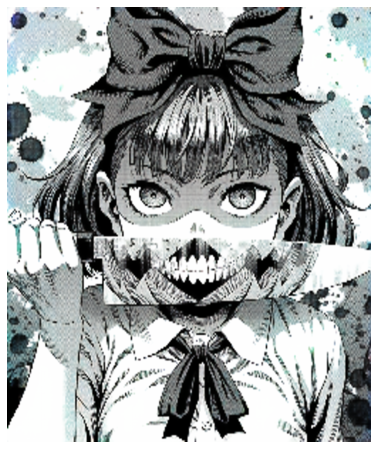

In [ ]:
generate_one_image(generatora200, img_name, inc_path)

# Loading and testing pix2pix: Anime as an example

In [ ]:
BUFFER_SIZE = 6500 # training image size

path_output = '/content/anime2/color'
path_input = '/content/anime2/grey'
path_names = '/content/anime2/all_images.csv'
files = pd.read_csv(path_names).image_name[BUFFER_SIZE+201:BUFFER_SIZE+209].tolist()

## tesing multiple images

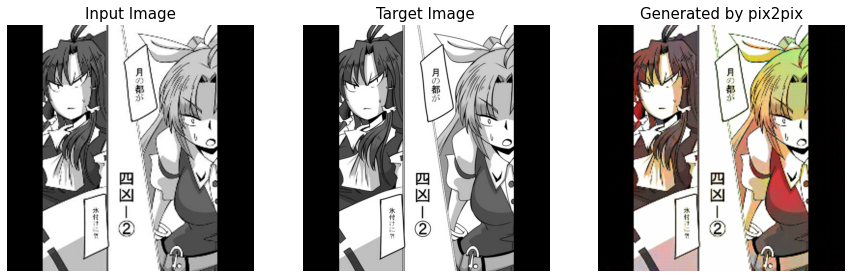

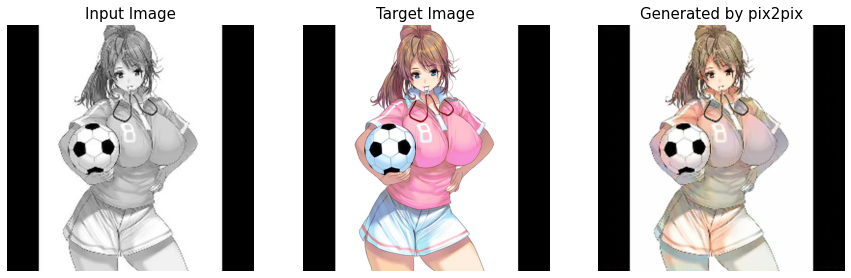

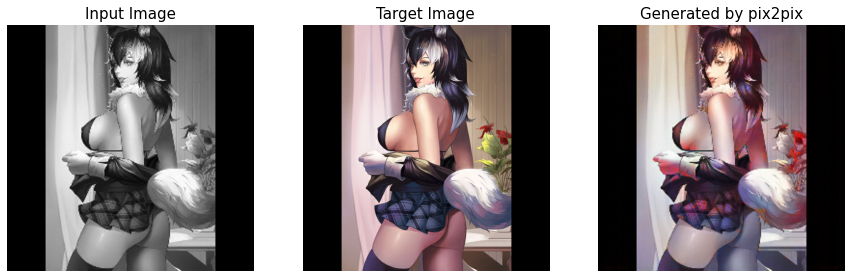

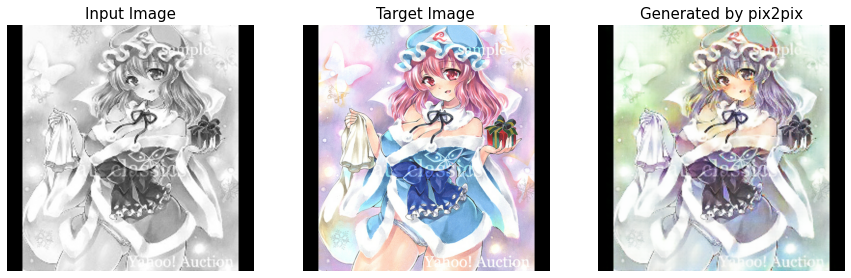

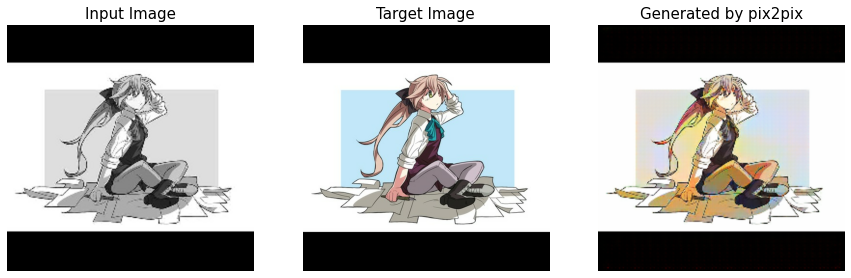

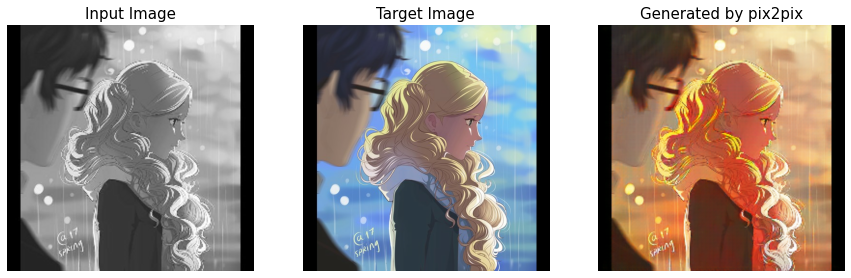

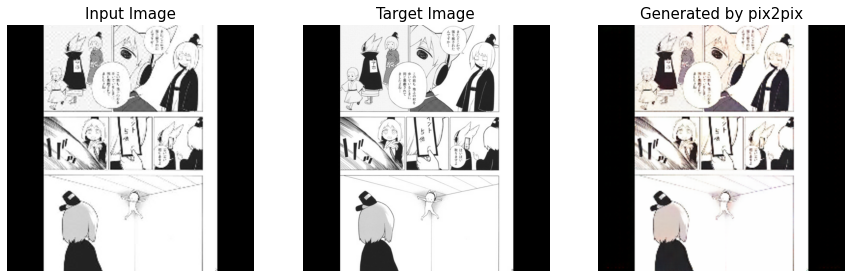

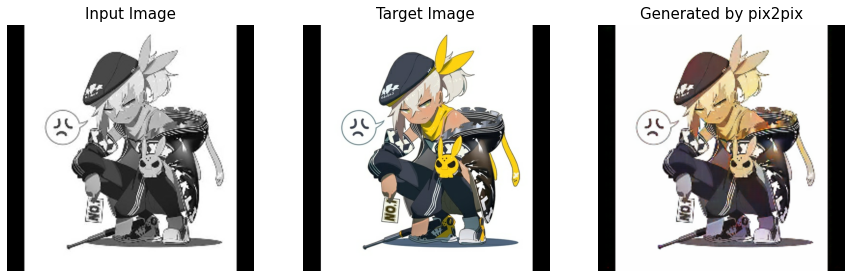

In [ ]:
generatora1000 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/model_anime1000e.h5')
generate_many_images(generatora1000, files, files, path_input, path_output)

## testing 1 image

In [ ]:
# img_name = files_input[6206]
# inc_path = '/content/E6893 Images/landscape/gray'

In [ ]:
img_name = 'test49.jpeg'
inc_path = '/content'

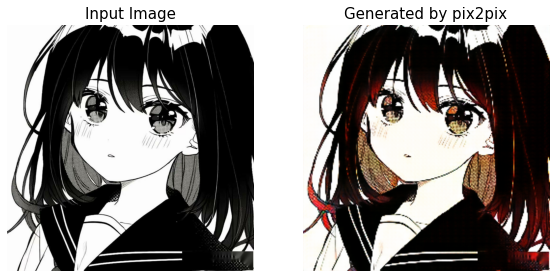

In [ ]:
generate_one_image(generatora1000, img_name, inc_path)